In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import json
import logging
from typing import Dict, Tuple, Optional
from dataclasses import dataclass, asdict

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, 
    Dropout, GRU, TimeDistributed, Dense
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, 
    TensorBoard, CSVLogger
)
from tensorflow.keras.optimizers import Adam
from pydub import AudioSegment
import IPython
from td_utils import *
import matplotlib.pyplot as plt
from pydub import AudioSegment
import IPython
%matplotlib inline

In [28]:
from keras.models import load_model

model = load_model("../models/wakeword_model.h5")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [29]:
# Load preprocessed dev set examples
import numpy as np
X_dev = np.load("../data/processed/dev/X.npy")
Y_dev = np.load("../data/processed/dev/Y.npy")

In [30]:
loss, acc, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.8442 - loss: 0.6893
Dev set accuracy =  0.8441818356513977


In [33]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    
    # Correct the amplitude of the input file before prediction 
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    file_handle = audio_clip.export("../audio/generated/tmp.wav", format="wav")
    filename = "tmp.wav"

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [34]:
chime_file = "../audio/sample/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    i = 0
    # Step 2: Loop over the output steps in the y
    while i < Ty:
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold for 20 consecutive output steps have passed
        if consecutive_timesteps > 20:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds) * 1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
            i = 75 * (i // 75 + 1)
            continue
        # if amplitude is smaller than the threshold reset the consecutive_timesteps counter
        if predictions[0, i, 0] < threshold:
            consecutive_timesteps = 0
        i += 1
        
    audio_clip.export("../audio/generated/chime_output.wav", format='wav')

In [7]:
# IPython.display.Audio("../data/raw_data/dev/1.wav")

C:\Users\Chathura\AppData\Local\Temp\ipykernel_15276\1246625803.py:14: MatplotlibDeprecationWarning: Passing the NFFT parameter of specgram() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


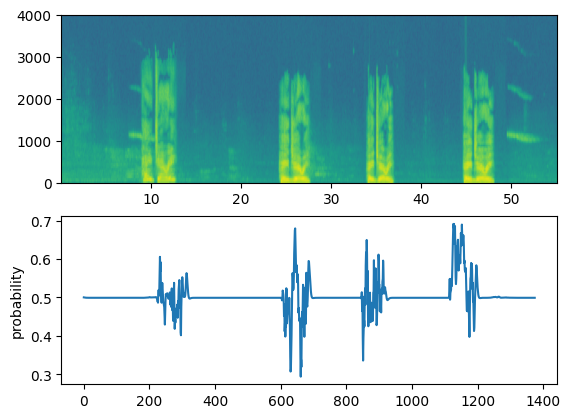

In [35]:
filename = "../audio/generated/train.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("../audio/generated/chime_output.wav")

In [ ]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [ ]:
def convert_to_wav(folder_path: str, audio_channels=2, audio_sample_rate=16000) -> int:
    from pydub import AudioSegment
    import glob, os

    audio_extensions = ['*.mp3', '*.m4a', '*.mp4', '*.flac', '*.ogg']
    audio_files = [f for ext in audio_extensions for f in glob.glob(os.path.join(folder_path, ext))]
    
    count = 0
    for file_path in audio_files:
        try:
            audio = AudioSegment.from_file(file_path)
            audio = audio.set_channels(audio_channels)
            audio = audio.set_frame_rate(audio_sample_rate)
            
            wav_path = os.path.splitext(file_path)[0] + '.wav'
            audio.export(wav_path, format='wav')
            
            os.remove(file_path)
            count += 1
            print(f"Converted: {os.path.basename(file_path)}")
        except Exception as e:
            print(f"Error converting {file_path}: {str(e)}")
    
    return count

# Call it directly
convert_to_wav(folder_path="../audio/sample/")


0

In [51]:
# Call it directly
convert_to_wav(folder_path="../audio/sample/")

0

In [52]:
your_filename = "../audio/sample/test-act.wav"

In [53]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


C:\Users\Chathura\AppData\Local\Temp\ipykernel_15276\1246625803.py:14: MatplotlibDeprecationWarning: Passing the NFFT parameter of specgram() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)


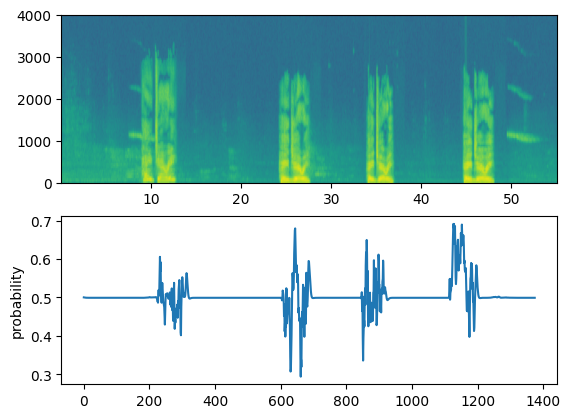

In [48]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("../audio/generated/chime_output.wav")

In [1]:
# Wake Word Detection - Model Testing & Inference
# This notebook loads the trained model and performs wake word detection
# on audio samples, adding a chime sound when the wake word is detected

# ============================================================================
# SECTION 1: Setup and Imports
# ============================================================================

import os
import glob
import json
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple, Optional
from dataclasses import dataclass, asdict

import numpy as np
import matplotlib.pyplot as plt
import IPython

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, 
    Dropout, GRU, TimeDistributed, Dense
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, 
    TensorBoard, CSVLogger
)
from tensorflow.keras.optimizers import Adam

from pydub import AudioSegment
from td_utils import *

# Configure plotting
%matplotlib inline
plt.style.use('default')

print("✓ All libraries imported successfully!\n")

✓ All libraries imported successfully!



In [10]:
# ============================================================================
# SECTION 2: Configuration
# ============================================================================

# File paths
MODEL_PATH = "../models/wakeword_model.h5"
DEV_DATA_PATH = "../data/processed/dev"
AUDIO_SAMPLE_PATH = "../audio/sample"
AUDIO_GENERATED_PATH = "../audio/generated"
CHIME_FILE = "../audio/sample/chime.wav"

# Detection parameters
CHIME_THRESHOLD = 0.7  # Probability threshold for wake word detection
CONSECUTIVE_STEPS = 20  # Number of consecutive high-probability steps required
COOLDOWN_STEPS = 75  # Steps to wait after detection before detecting again

# Audio parameters
TARGET_AMPLITUDE = -20.0  # dBFS
AUDIO_DURATION = 10000  # milliseconds (10 seconds)
SAMPLE_RATE = 44100  # Hz

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"Model path: {MODEL_PATH}")
print(f"Detection threshold: {CHIME_THRESHOLD}")
print(f"Consecutive steps required: {CONSECUTIVE_STEPS}")
print(f"Audio duration: {AUDIO_DURATION} ms")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print("="*60 + "\n")

CONFIGURATION
Model path: ../models/wakeword_model.h5
Detection threshold: 0.7
Consecutive steps required: 20
Audio duration: 10000 ms
Sample rate: 44100 Hz



In [11]:
# ============================================================================
# SECTION 3: Load Trained Model
# ============================================================================

print("Loading trained model...")

try:
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully!")
    print(f"   Model path: {MODEL_PATH}")
    print(f"   Total parameters: {model.count_params():,}\n")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

Loading trained model...
✅ Model loaded successfully!
   Model path: ../models/wakeword_model.h5
   Total parameters: 523,329



In [12]:
# ============================================================================
# SECTION 4: Evaluate on Development Set
# ============================================================================

print("="*60)
print("DEVELOPMENT SET EVALUATION")
print("="*60)

# Load development set
print("Loading development set...")
X_dev = np.load(f"{DEV_DATA_PATH}/X.npy")
Y_dev = np.load(f"{DEV_DATA_PATH}/Y.npy")

print(f"✓ Development set loaded")
print(f"  X_dev shape: {X_dev.shape}")
print(f"  Y_dev shape: {Y_dev.shape}\n")

# Evaluate model
print("Evaluating model on development set...")
loss, accuracy = model.evaluate(X_dev, Y_dev, verbose=1)

print(f"\n{'='*60}")
print(f"EVALUATION RESULTS")
print(f"{'='*60}")
print(f"Development Set Loss: {loss:.6f}")
print(f"Development Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"{'='*60}\n")

DEVELOPMENT SET EVALUATION
Loading development set...
✓ Development set loaded
  X_dev shape: (4, 5511, 101)
  Y_dev shape: (4, 1375, 1)

Evaluating model on development set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.8540 - loss: 0.6882

EVALUATION RESULTS
Development Set Loss: 0.688178
Development Set Accuracy: 0.8540 (85.40%)



In [13]:
# ============================================================================
# SECTION 5: Audio Preprocessing Utilities
# ============================================================================

def preprocess_audio(filename: str) -> None:
    """
    Preprocess audio file to standard format:
    - Trim or pad to 10 seconds
    - Set frame rate to 44100 Hz
    
    Parameters:
        filename (str): Path to audio file
    """
    try:
        # Create 10-second silent padding
        padding = AudioSegment.silent(duration=AUDIO_DURATION)
        
        # Load and trim/pad audio
        segment = AudioSegment.from_wav(filename)[:AUDIO_DURATION]
        segment = padding.overlay(segment)
        
        # Set standard frame rate
        segment = segment.set_frame_rate(SAMPLE_RATE)
        
        # Export preprocessed audio
        segment.export(filename, format='wav')
        print(f"✓ Preprocessed: {os.path.basename(filename)}")
        
    except Exception as e:
        print(f"❌ Error preprocessing {filename}: {e}")


def convert_to_wav(folder_path: str, 
                   audio_channels: int = 2, 
                   audio_sample_rate: int = 16000) -> int:
    """
    Convert audio files in a folder to WAV format.
    
    Parameters:
        folder_path (str): Path to folder containing audio files
        audio_channels (int): Number of audio channels
        audio_sample_rate (int): Sample rate in Hz
    
    Returns:
        int: Number of files converted
    """
    audio_extensions = ['*.mp3', '*.m4a', '*.mp4', '*.flac', '*.ogg']
    audio_files = [
        f for ext in audio_extensions 
        for f in glob.glob(os.path.join(folder_path, ext))
    ]
    
    if not audio_files:
        print(f"No audio files found in {folder_path}")
        return 0
    
    print(f"\nConverting {len(audio_files)} file(s) to WAV...")
    count = 0
    
    for file_path in audio_files:
        try:
            # Load and convert audio
            audio = AudioSegment.from_file(file_path)
            audio = audio.set_channels(audio_channels)
            audio = audio.set_frame_rate(audio_sample_rate)
            
            # Export as WAV
            wav_path = os.path.splitext(file_path)[0] + '.wav'
            audio.export(wav_path, format='wav')
            
            # Remove original file
            os.remove(file_path)
            count += 1
            print(f"  ✓ Converted: {os.path.basename(file_path)} → {os.path.basename(wav_path)}")
            
        except Exception as e:
            print(f"  ❌ Error converting {file_path}: {e}")
    
    print(f"\n✓ Conversion complete! {count}/{len(audio_files)} files converted\n")
    return count


print("Audio preprocessing utilities defined\n")

Audio preprocessing utilities defined



In [14]:
# ============================================================================
# SECTION 6: Wake Word Detection Functions
# ============================================================================

def detect_triggerword(filename: str) -> np.ndarray:
    """
    Detect wake word in audio file and visualize predictions.
    
    Parameters:
        filename (str): Path to audio file
    
    Returns:
        np.ndarray: Model predictions with shape (1, Ty, 1)
    """
    # Create figure with two subplots
    plt.figure(figsize=(14, 8))
    
    # Subplot 1: Spectrogram
    plt.subplot(2, 1, 1)
    
    # Normalize audio amplitude
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, TARGET_AMPLITUDE)
    
    # Export temporary normalized file
    temp_file = os.path.join(AUDIO_GENERATED_PATH, "tmp.wav")
    audio_clip.export(temp_file, format="wav")
    
    # Generate spectrogram
    x = graph_spectrogram(temp_file)
    
    # Reshape for model input: (freqs, Tx) → (1, Tx, freqs)
    x = x.swapaxes(0, 1)
    x = np.expand_dims(x, axis=0)
    
    # Get predictions
    predictions = model.predict(x, verbose=0)
    
    # Subplot 2: Prediction probability over time
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0, :, 0], linewidth=2, color='blue')
    plt.axhline(y=CHIME_THRESHOLD, color='red', linestyle='--', 
                label=f'Threshold ({CHIME_THRESHOLD})', linewidth=1.5)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title('Wake Word Detection Probability', fontsize=14, fontweight='bold')
    plt.ylim([0, 1])
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return predictions


def chime_on_activate(filename: str, 
                     predictions: np.ndarray, 
                     threshold: float) -> None:
    """
    Add chime sound when wake word is detected with high confidence.
    
    Algorithm:
        1. Track consecutive high-probability time steps
        2. When threshold exceeded for CONSECUTIVE_STEPS, add chime
        3. Implement cooldown period to avoid multiple chimes
    
    Parameters:
        filename (str): Path to input audio file
        predictions (np.ndarray): Model predictions
        threshold (float): Detection threshold
    """
    # Load audio files
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(CHIME_FILE)
    
    Ty = predictions.shape[1]
    consecutive_timesteps = 0
    i = 0
    
    print(f"\nProcessing {Ty} time steps...")
    detection_count = 0
    
    # Loop over output time steps
    while i < Ty:
        consecutive_timesteps += 1
        
        # Check if wake word detected
        if consecutive_timesteps > CONSECUTIVE_STEPS:
            # Calculate position in audio (in milliseconds)
            position_ms = ((i / Ty) * audio_clip.duration_seconds) * 1000
            
            # Overlay chime at detected position
            audio_clip = audio_clip.overlay(chime, position=position_ms)
            
            detection_count += 1
            print(f"  ✓ Detection #{detection_count} at time step {i} "
                  f"({position_ms/1000:.2f}s)")
            
            # Reset counter and apply cooldown
            consecutive_timesteps = 0
            i = COOLDOWN_STEPS * (i // COOLDOWN_STEPS + 1)
            continue
        
        # Reset counter if below threshold
        if predictions[0, i, 0] < threshold:
            consecutive_timesteps = 0
        
        i += 1
    
    # Export result
    output_path = os.path.join(AUDIO_GENERATED_PATH, "chime_output.wav")
    audio_clip.export(output_path, format='wav')
    
    print(f"\n✓ Total detections: {detection_count}")
    print(f"✓ Output saved to: {output_path}\n")


print("Wake word detection functions defined\n")

Wake word detection functions defined



TEST 1: TRAINING SAMPLE
Testing on: ../audio/generated/train.wav



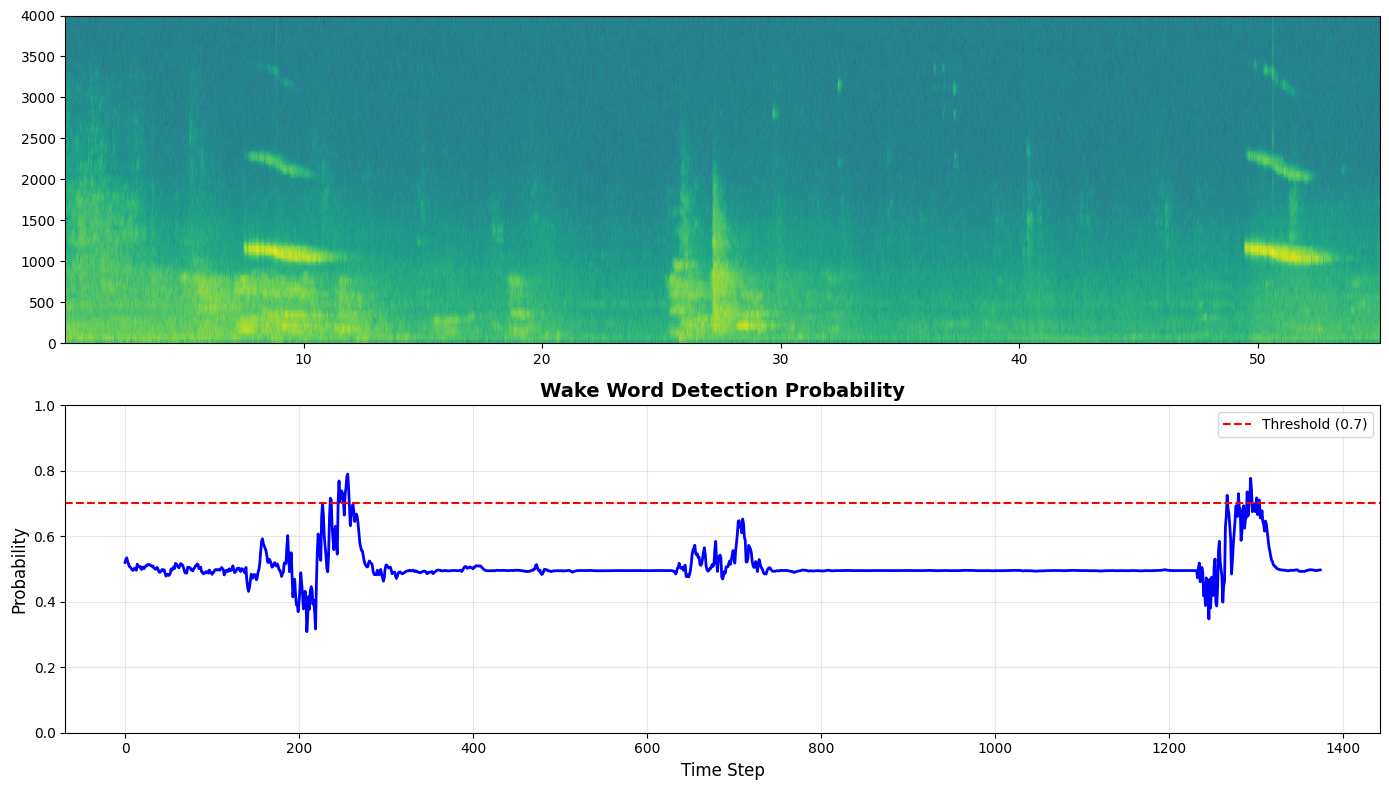


Processing 1375 time steps...

✓ Total detections: 0
✓ Output saved to: ../audio/generated\chime_output.wav

Playing result with chime:


In [15]:
# ============================================================================
# SECTION 7: Test on Training Sample
# ============================================================================

print("="*60)
print("TEST 1: TRAINING SAMPLE")
print("="*60)

# Test on a training example
train_sample = "../audio/generated/train.wav"

print(f"Testing on: {train_sample}\n")

# Detect wake word and visualize
prediction = detect_triggerword(train_sample)

# Add chime on detection
chime_on_activate(train_sample, prediction, CHIME_THRESHOLD)

# Play result
print("Playing result with chime:")
IPython.display.Audio("../audio/generated/chime_output.wav")

In [16]:
# ============================================================================
# SECTION 8: Convert Sample Audio Files
# ============================================================================

print("\n" + "="*60)
print("AUDIO FILE CONVERSION")
print("="*60)

# Convert any non-WAV files in sample folder
converted_count = convert_to_wav(
    folder_path=AUDIO_SAMPLE_PATH,
    audio_channels=2,
    audio_sample_rate=16000
)

if converted_count == 0:
    print("All audio files are already in WAV format\n")


AUDIO FILE CONVERSION
No audio files found in ../audio/sample
All audio files are already in WAV format



TEST 2: CUSTOM AUDIO SAMPLE
Testing on: ../audio/sample/test-act.wav

Preprocessing audio...
✓ Preprocessed: test-act.wav

🔊 Playing original audio:

Detecting wake word...


d:\FOR_PORTFOLIO_REPO\wake-word-detection\wakeword-env\Lib\site-packages\matplotlib\axes\_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


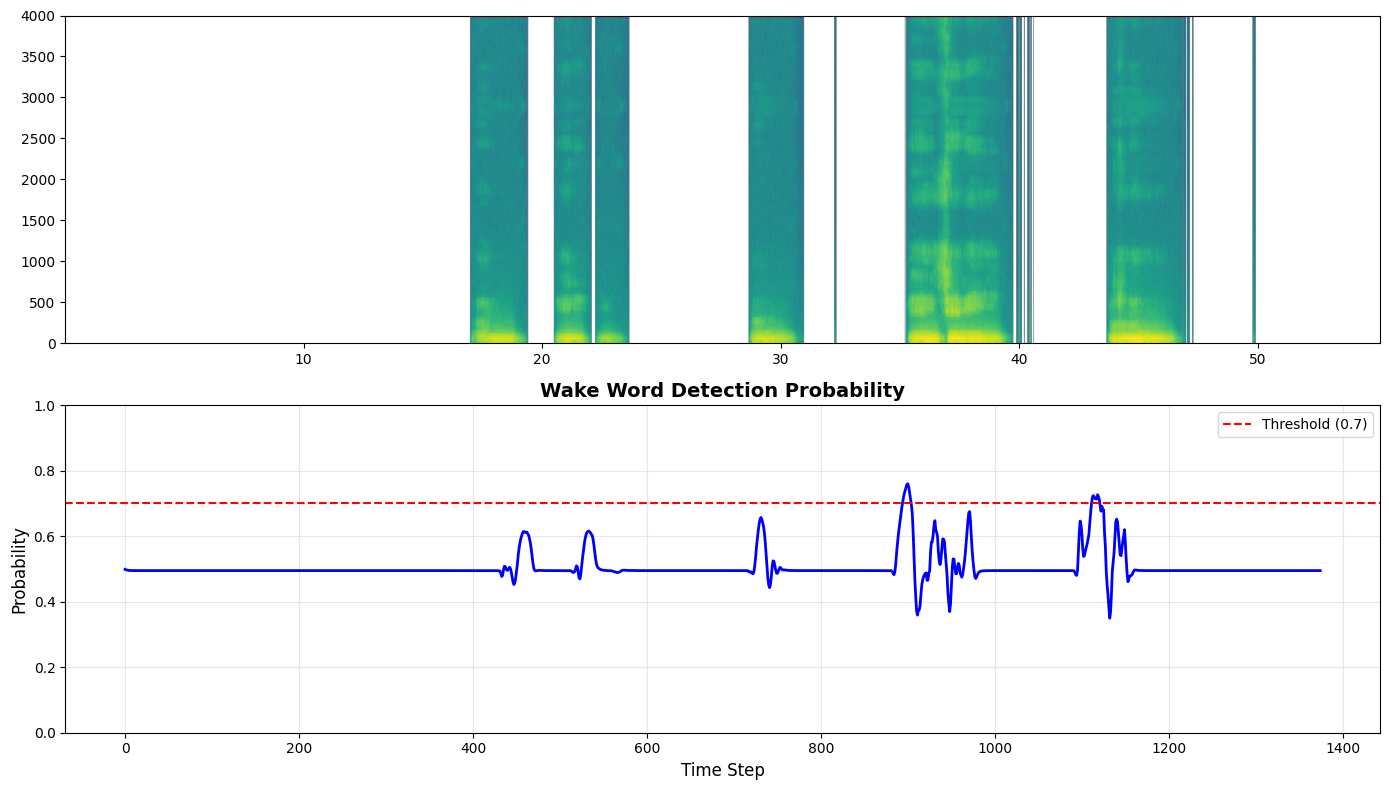


Processing 1375 time steps...

✓ Total detections: 0
✓ Output saved to: ../audio/generated\chime_output.wav


🔊 Playing result with chime:


In [17]:
# ============================================================================
# SECTION 9: Test on Custom Audio Sample
# ============================================================================

print("="*60)
print("TEST 2: CUSTOM AUDIO SAMPLE")
print("="*60)

# Specify your test audio file
test_audio = "../audio/sample/test-act.wav"

if os.path.exists(test_audio):
    print(f"Testing on: {test_audio}\n")
    
    # Preprocess audio
    print("Preprocessing audio...")
    preprocess_audio(test_audio)
    
    # Listen to original
    print("\n🔊 Playing original audio:")
    IPython.display.Audio(test_audio)
    
    # Detect wake word
    print("\nDetecting wake word...")
    prediction = detect_triggerword(test_audio)
    
    # Add chime on detection
    chime_on_activate(test_audio, prediction, CHIME_THRESHOLD)
    
    # Play result
    print("\n🔊 Playing result with chime:")
    IPython.display.Audio("../audio/generated/chime_output.wav")
    
else:
    print(f"⚠️  Test file not found: {test_audio}")
    print("Please update the path to your test audio file\n")

In [18]:
# ============================================================================
# SECTION 10: Batch Testing Utility
# ============================================================================

def batch_test_audio_files(folder_path: str, threshold: float = 0.5) -> Dict:
    """
    Test multiple audio files in a folder and generate report.
    
    Parameters:
        folder_path (str): Path to folder containing audio files
        threshold (float): Detection threshold
    
    Returns:
        Dict: Testing results summary
    """
    wav_files = glob.glob(os.path.join(folder_path, "*.wav"))
    
    if not wav_files:
        print(f"No WAV files found in {folder_path}")
        return {}
    
    print(f"\n{'='*60}")
    print(f"BATCH TESTING: {len(wav_files)} FILES")
    print(f"{'='*60}\n")
    
    results = {
        'total_files': len(wav_files),
        'files_tested': 0,
        'files_with_detections': 0,
        'total_detections': 0,
        'file_results': []
    }
    
    for idx, file_path in enumerate(wav_files, 1):
        filename = os.path.basename(file_path)
        print(f"[{idx}/{len(wav_files)}] Testing: {filename}")
        
        try:
            # Preprocess
            preprocess_audio(file_path)
            
            # Detect
            predictions = detect_triggerword(file_path)
            
            # Count detections
            Ty = predictions.shape[1]
            detection_count = 0
            consecutive = 0
            
            for i in range(Ty):
                consecutive += 1
                
                if consecutive > CONSECUTIVE_STEPS:
                    detection_count += 1
                    consecutive = 0
                    i = COOLDOWN_STEPS * (i // COOLDOWN_STEPS + 1)
                    continue
                
                if predictions[0, i, 0] < threshold:
                    consecutive = 0
            
            results['files_tested'] += 1
            results['total_detections'] += detection_count
            
            if detection_count > 0:
                results['files_with_detections'] += 1
            
            results['file_results'].append({
                'filename': filename,
                'detections': detection_count
            })
            
            print(f"  → Detections: {detection_count}\n")
            
        except Exception as e:
            print(f"  ❌ Error: {e}\n")
    
    # Print summary
    print(f"{'='*60}")
    print("BATCH TESTING SUMMARY")
    print(f"{'='*60}")
    print(f"Files tested: {results['files_tested']}/{results['total_files']}")
    print(f"Files with detections: {results['files_with_detections']}")
    print(f"Total detections: {results['total_detections']}")
    print(f"{'='*60}\n")
    
    return results


# Example: Uncomment to run batch testing
# batch_results = batch_test_audio_files(AUDIO_SAMPLE_PATH, CHIME_THRESHOLD)

In [19]:
# ============================================================================
# SECTION 11: Interactive Testing Interface
# ============================================================================

print("\n" + "="*60)
print("INTERACTIVE TESTING")
print("="*60)
print("""
To test your own audio files:

1. Place your WAV file in: ../audio/sample/
2. Update the test_audio path in Section 9
3. Run the detection cells

You can also adjust the detection threshold:
    - Lower threshold (e.g., 0.3): More sensitive, more false positives
    - Higher threshold (e.g., 0.7): Less sensitive, fewer false positives
    
Current threshold: {:.1f}
""".format(CHIME_THRESHOLD))
print("="*60)

print("\n" + "="*60)
print("TESTING COMPLETE!")
print("="*60)
print("\nNext steps:")
print("  1. Test with your own audio samples")
print("  2. Adjust threshold for optimal performance")
print("  3. Try batch testing on multiple files")
print("  4. Deploy model for real-time detection")
print("="*60)


INTERACTIVE TESTING

To test your own audio files:

1. Place your WAV file in: ../audio/sample/
2. Update the test_audio path in Section 9
3. Run the detection cells

You can also adjust the detection threshold:
    - Lower threshold (e.g., 0.3): More sensitive, more false positives
    - Higher threshold (e.g., 0.7): Less sensitive, fewer false positives

Current threshold: 0.7


TESTING COMPLETE!

Next steps:
  1. Test with your own audio samples
  2. Adjust threshold for optimal performance
  3. Try batch testing on multiple files
  4. Deploy model for real-time detection
